In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
%matplotlib notebook

<ipython-input-1-ecb51f2daeeb>:2: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib.pyplot as plt


In [2]:
# tools
def set_prop_cycle(self, clist):
    """
    Set the color cycle for any future plot commands on this Axes.

    *clist* is a list of mpl color specifiers.
    """
    self._get_lines.set_color_cycle(clist)
    self._get_patches_for_fill.set_color_cycle(clist)

In [3]:
# Network
REFRAC_TIME = 40
VTHRES = 10
VRESET = -1
SPIKE_RES = 1000
def membrane(syn_input, old_membrane, refractory_time,
REFRAC_TIME = REFRAC_TIME, vthres=VTHRES, v_reset = VRESET, dt=1, tau_mem=10):
    if refractory_time > 0:
        refractory_time -= 1
        spiking = False
        return v_reset, refractory_time, spiking
    elif (old_membrane + syn_input) > vthres:
        spiking = True
        refractory_time = REFRAC_TIME
        return v_reset, refractory_time, spiking
    else:
        spiking = False
        return (old_membrane + syn_input)*np.exp(-dt/tau_mem), refractory_time, spiking

def spike(time, tau_syn=5, res = SPIKE_RES, single_exp=False):
    trace = np.zeros(res)
    if time is not None:
        time = int(time)
        trace[time] = 1
        if single_exp:
            spike_kernel = single_exp_kernel(tau_syn)
        else:
            spike_kernel = kernel(tau_syn)
        trace = np.convolve(spike_kernel, trace)[:res]
    return trace

def spike_(time, tau_syn=5, res = SPIKE_RES):
    trace = np.zeros(res)
    if time is not None:
        time = int(time)
        trace[time] = 1
        spike_kernel = kernel(tau_syn)
        trace = np.convolve(spike_kernel, trace)[:res]
    return trace

def nospike(res=SPIKE_RES):
    return np.zeros(res)


def membrane_trace(syn_input_tr, vthres=VTHRES, vreset=VRESET, refrac=REFRAC_TIME):
    n = len(syn_input_tr)
    mem_tr = np.zeros(n)
    spiking_tr = np.zeros(n)
    remaining_refrac_time = 0
    
    for i in range(n):
        mem_tr[i], remaining_refrac_time, spiking_tr[i] = membrane(syn_input_tr[i], mem_tr[i - 1], 
                                                                  remaining_refrac_time, vthres=vthres,
                                                                  v_reset=vreset, REFRAC_TIME=refrac)
    return mem_tr, spiking_tr

# INPUT:
# a pattern (2d image) is mapped to a spiketrain (pattern2spiketrain)
# a spiketrain turned into a trace (spiketrain2trace)
# the trace is then folded with the weight matrix resulting in the synaptic input of the next layer (tracexweight)
# the 

# HIDDEN:
# 



def pattern2spiketrain(pattern, early=10, late=90, jitter=5):
    # returns a (n x 2) array with n spikes containing spike time and firing unit
    # array([(time, unit),
    #         ...])
    n = len(pattern)
    spiketrain = np.zeros((n, 2))
    noise = np.random.randint(-jitter,jitter,size=n)
    for i, p in enumerate(pattern):
        spiketrain[i, 0] = (early if p == 1 else late) + noise[i]
        spiketrain[i, 1] = i
    return spiketrain


def spiketrain2trace(spiketrain, n_units):
    # spiketrain: (nx2), n #spikes
    # return trace: (#units, time)
    trace = np.zeros((n_units, SPIKE_RES))
    for time, unit in spiketrain:
        if time is not None:
            trace[int(unit)] += spike(int(time))
        else:
            pass
    return trace

def tracexweight(trace, weights):
    # weights: (m, n) where m is #inputs and n #outputs
    # trace: (m, t) where m is #inputs and t the time dim
    # return: (n,t)
    return (weights.T[:,:,None]*trace[None, :,:]).sum(axis=1)


def spikingtr2spiketrain(spiking_tr):
    # spiking_tr: (#units, time), boolean array with "true" where a unit fired
    # return: a (#spikes x 2) array with #spikes where each spike contains spike time and firing unit
    spiketrain = None
    for unit, spiking in enumerate(spiking_tr):
        spiketimes = (spiking*range(SPIKE_RES))[spiking.astype(bool)]
        if len(spiketimes) != 0:
            if spiketrain is not None:
                spiketrain = np.vstack((spiketrain, np.array(list(zip(spiketimes, len(spiketimes)*[unit])))))
            else:
                spiketrain = np.array(list(zip(spiketimes, len(spiketimes)*[unit])))
    if spiketrain is None:
        return np.array([[None,None]])
    else:
        return spiketrain
    
def kernel(tau, res=200, normed=True):
    x = np.arange(res)
    ker = x*np.exp(-x/tau)
    if normed:
        ker /= sum(ker)
    return ker

def single_exp_kernel(tau, res=200, normed=True):
    x = np.arange(res)
    ker = np.exp(-x/tau)
    if normed:
        ker /= sum(ker)
    return ker


In [4]:
tau_mem = 7e-6
tau_syn = 7e-6
tau_eps = 5e-6
tau_alpha = 10e-6

samplingperiode = 1e-6
# update parameters
tau_mem /= samplingperiode
tau_syn /= samplingperiode
tau_eps /= samplingperiode
tau_alpha /= samplingperiode

eps = kernel(tau_eps)
eps_single = single_exp_kernel(tau_eps)
alpha = kernel(tau_alpha)
syn_input = spike(20e-6/samplingperiode, tau_syn=tau_syn)
syn_input_single =  spike(20e-6/samplingperiode, tau_syn=tau_syn, single_exp=True)
mem_tr, _ = membrane_trace(syn_input)
mem_tr_single, _ = membrane_trace(syn_input_single)
#fig, axes = plt.subplots(2)
#axes[0].plot(syn_input, label="syn input")
#axes[0].plot(syn_input_single, label="syn input single exp")
#axes[0].plot(eps, label="eps kernel")
#axes[0].plot(eps_single, label="eps single exp kernel")
#axes[0].plot(alpha, label="alpha kernel")
#axes[0].legend()
#axes[1].plot(mem_tr, label="mem trace")
#axes[1].plot(mem_tr_single, label="mem trace single exp input")
#axes[1].legend()
#axes[1].set_xlabel("time in %s s" % samplingperiode)

max frequency 25000.000000000004


<IPython.core.display.Javascript object>


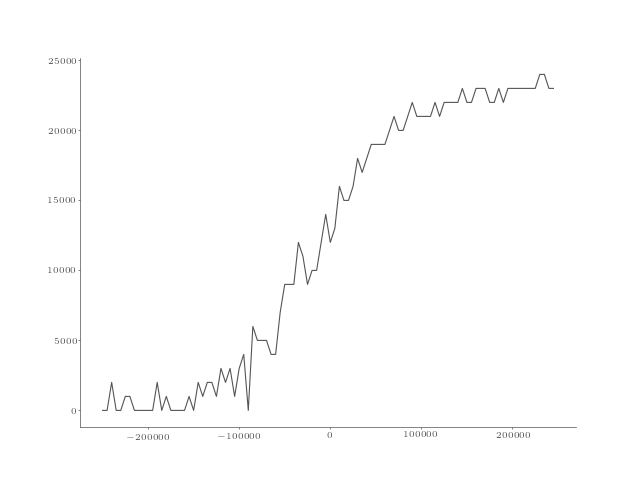

In [6]:
freq_input_sequence = np.arange(-250e3, 250e3, 5e3)
w_noise=0.4
w_input=0.8
vthres = 0.00
vreset = vthres -.5
refrac = 40
print("max frequency", 1/(refrac*1e-6))
period = SPIKE_RES*1e-6 #µs
freq_noise = 70e3 #Hz
freq_output_sequence = np.zeros_like(freq_input_sequence)
for i, freq_input in enumerate(freq_input_sequence):
    #print("input freq:", freq_input*1e-3 , "kHz")
    # synaptic noise input
    n_noise_spikes = np.int(freq_noise*period)
    noise_spiketimes = np.random.randint(0,SPIKE_RES, size=2*n_noise_spikes)
    noise_spiketrain = np.array(list(zip(noise_spiketimes, [0,]*n_noise_spikes + [1,]*n_noise_spikes)))
    synaptic_input_exc_inh = spiketrain2trace(noise_spiketrain, 2)
    synaptic_noise_input = synaptic_input_exc_inh[1] - synaptic_input_exc_inh[0]
    synaptic_noise_input *= w_noise

    # synaptic input
    sign = np.sign(freq_input)
    freq_input *= sign
    n_spikes = np.int(freq_input*period)
    spiketimes = np.random.randint(0,SPIKE_RES, size=n_spikes)
    spiketrain = np.array(list(zip(spiketimes, [0,]*n_spikes)))
    synaptic_input = spiketrain2trace(spiketrain, 1)
    synaptic_input *= w_input

    total_synaptic_input = synaptic_noise_input + sign*synaptic_input[0]

    # membrane trace
    mem_tr, spiking_tr = membrane_trace(total_synaptic_input,vthres=vthres, vreset=vreset,refrac=refrac)
    freq_output_sequence[i] = spiking_tr.sum()/period

plt.figure()
plt.plot(freq_input_sequence, freq_output_sequence)

<IPython.core.display.Javascript object>


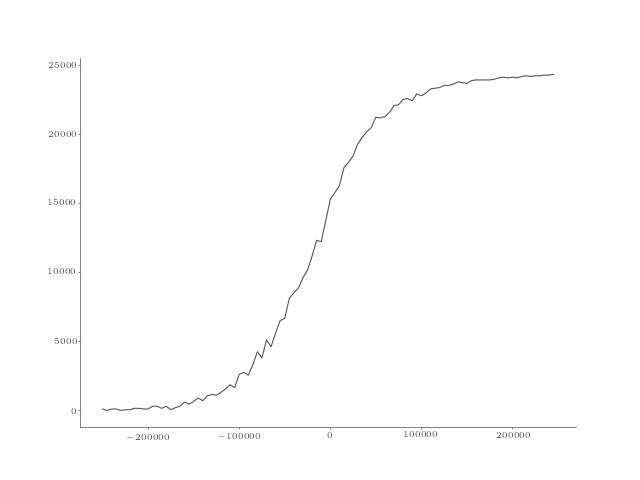

In [223]:
plt.figure()
plt.plot(freq_input_sequence, freq_output_sequence)

In [222]:
np.savez("sigmoid_mmnt_%s" % SPIKE_RES, 
         freq_input_sequence = freq_input_sequence,
         freq_output_sequence = freq_output_sequence,
         w_noise = w_noise,
         w_input = w_input,
         freq_noise = freq_noise,
         vthres = vthres,
         vreset = vreset,
         refrac = refrac,
        period = period)

In [271]:
freq_input = 0
w_noise=0.5
w_input=0.8
vthres = 10.00
vreset = vthres - 0.1
refrac = 40
period = SPIKE_RES*1e-6 #µs
freq_noise = 70e3 #Hz
print("input freq:", freq_input*1e-3 , "kHz")
# synaptic noise input
n_noise_spikes = np.int(freq_noise*period)
noise_spiketimes = np.random.randint(0,SPIKE_RES, size=2*n_noise_spikes)
noise_spiketrain = np.array(list(zip(noise_spiketimes, [0,]*n_noise_spikes + [1,]*n_noise_spikes)))
synaptic_input_exc_inh = spiketrain2trace(noise_spiketrain, 2)
synaptic_noise_input = synaptic_input_exc_inh[1] - synaptic_input_exc_inh[0]
synaptic_noise_input *= w_noise

# synaptic input
sign = np.sign(freq_input)
freq_input *= sign
n_spikes = np.int(freq_input*period)
spiketimes = np.random.randint(0,SPIKE_RES, size=n_spikes)
spiketrain = np.array(list(zip(spiketimes, [0,]*n_spikes)))
synaptic_input = spiketrain2trace(spiketrain, 1)
synaptic_input *= w_input
total_synaptic_input = synaptic_noise_input + sign*synaptic_input[0]

# membrane trace
mem_tr, spiking_tr = membrane_trace(total_synaptic_input,vthres=vthres, vreset=vreset,refrac=refrac)
freq_output_sequence[i] = spiking_tr.sum()/period
print("output freq", freq_output_sequence[i])
print("max freq ", 1/((refrac+1)*1e-6))



input freq: 0.0 kHz
output freq 0.0
max freq  24390.243902439022


In [272]:
np.savez("free_membrane_mmnt_%s" % SPIKE_RES, 
         mem_tr= mem_tr,
         w_noise = w_noise,
         w_input = w_input,
         freq_noise = freq_noise,
         vthres = vthres,
         vreset = vreset,
         refrac = refrac,
        period = period)

<IPython.core.display.Javascript object>


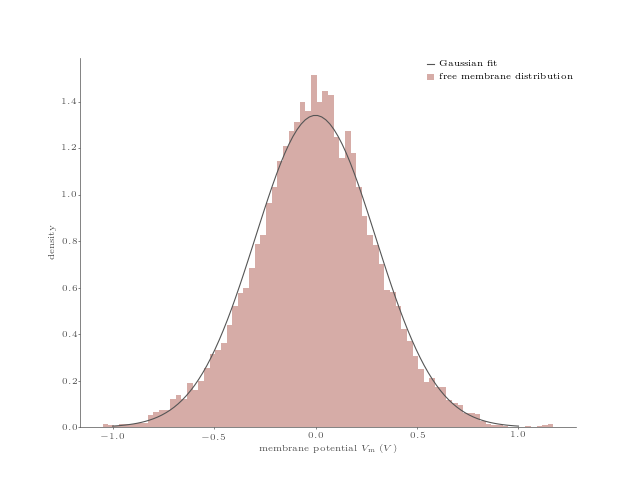

In [273]:
def gaus(x, mue, sig):
    return np.exp(-(x - mue) ** 2 / (2 * sig ** 2)) / sig / np.sqrt(2 * np.pi)
x = np.linspace(-1,1,100)
gaus_fit = gaus(x, mem_tr.mean(), np.std(mem_tr))

plt.figure()
plt.ylabel("density")
plt.xlabel("membrane potential $V_\mathrm{m} \; (V)$")
plt.plot(x, gaus_fit, label="Gaussian fit")
plt.hist(mem_tr, bins='fd', density=True, alpha=0.5, label="free membrane distribution")
plt.legend()

<IPython.core.display.Javascript object>


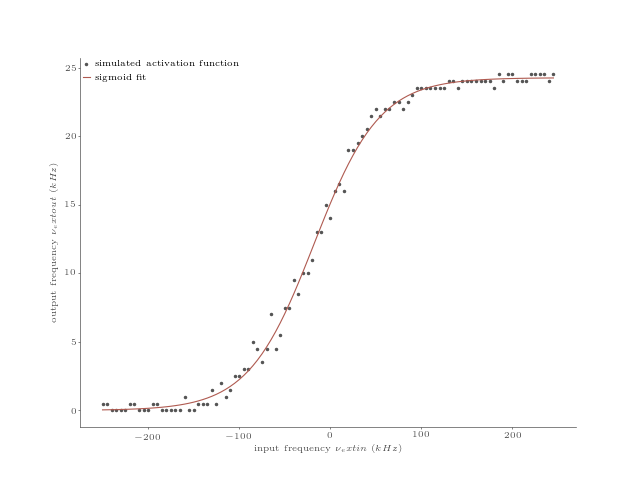

In [277]:
from scipy.optimize import curve_fit
sigmoid_mmnt_npz = np.load("sigmoid_mmnt_2000.npz")
freq_in = sigmoid_mmnt_npz["freq_input_sequence"]/1e3
freq_out = sigmoid_mmnt_npz["freq_output_sequence"]/1e3


# sigmoid fit
def fsigmoid(x,vmax, a, b):
    return vmax / (1.0 + np.exp(-a*(x-b)))
popt1, pcov1 = curve_fit(fsigmoid, freq_in, freq_out, method='dogbox', bounds=([0, 0., -10000],[100, 0.1, 10000.]))

plt.figure()
plt.plot(freq_in, freq_out, '.', label="simulated activation function")
plt.plot(freq_in, fsigmoid(freq_in, *popt1), label="sigmoid fit")
plt.xlabel("input frequency $\\nu_\text{in}\; (k Hz)$")
plt.ylabel("output frequency $\\nu_\text{out}\; (k Hz)$")
plt.legend()

In [280]:
SPIKE_RES

20000

<IPython.core.display.Javascript object>


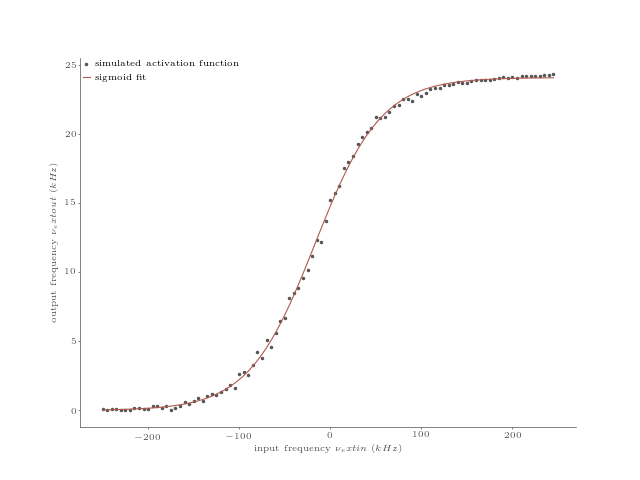

[ 24.07407523   0.02746355 -16.8227705 ]


In [282]:
from scipy.optimize import curve_fit
sigmoid_mmnt_npz = np.load("sigmoid_mmnt_20000.npz")
freq_in = sigmoid_mmnt_npz["freq_input_sequence"]/1e3
freq_out = sigmoid_mmnt_npz["freq_output_sequence"]/1e3


# sigmoid fit
def fsigmoid(x,vmax, a, b):
    return vmax / (1.0 + np.exp(-a*(x-b)))
popt1, pcov1 = curve_fit(fsigmoid, freq_in, freq_out, method='dogbox', bounds=([0, 0., -10000],[100, 0.1, 10000.]))

plt.figure()
plt.plot(freq_in, freq_out, '.', label="simulated activation function")
plt.plot(freq_in, fsigmoid(freq_in, *popt1), label="sigmoid fit")
plt.xlabel("input frequency $\\nu_\text{in}\; (k Hz)$")
plt.ylabel("output frequency $\\nu_\text{out}\; (k Hz)$")
plt.legend()
print(popt1)

<IPython.core.display.Javascript object>


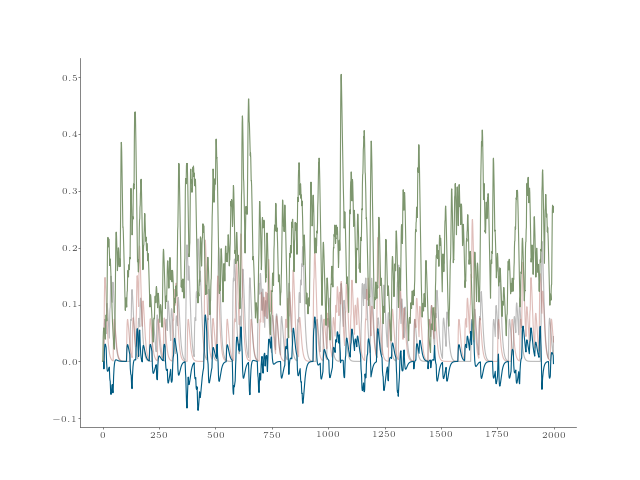

In [176]:
plt.figure()
plt.plot(sign*synaptic_input_exc_inh[0], alpha=0.4)
plt.plot(synaptic_input_exc_inh[1], alpha=0.4)
plt.plot(synaptic_noise_input)
plt.plot(synaptic_input[0])


In [181]:
10200/256

39.84375